# Clustering with pytorch

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
%matplotlib inline
import math, numpy as np, matplotlib.pyplot as plt, operator, torch

## Create data

In [2]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [20]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

In [32]:
# Save data so we can show consistent results
np.save('tmp/meanshift_data.npy', data)

In [31]:
data = np.load('tmp/meanshift_data.npy')

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [33]:
def plot_data(centroids, data, n_samples):
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        plt.scatter(samples[:,0], samples[:,1], c=colour[i], s=1)
        plt.plot(centroid[0], centroid[1], markersize=10, marker="x", color='k', mew=5)
        plt.plot(centroid[0], centroid[1], markersize=5, marker="x", color='m', mew=2)

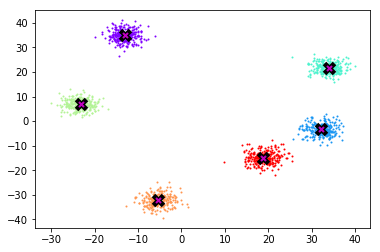

In [34]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
![Gaussian](http://images.books24x7.com/bookimages/id_5642/fig11-10.jpg)
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

So here's the definition of the gaussian kernel, which you may remember from high school...

In [187]:
from numpy import exp, sqrt, array

In [188]:
def gaussian(d, bw): return exp(-0.5*((d/bw))**2) / (bw * math.sqrt(2*math.pi))

 This person at the science march certainly remembered!

<img src="images/normal.jpg" width=400>

Since all of our distances are positive, we'll only be using the right-hand side of the gaussian. Here's what that looks like for a couple of different choices of bandwidth (bw).

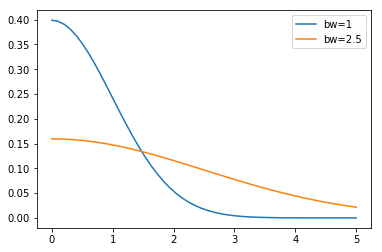

In [189]:
x=np.linspace(0,5)
fig, ax = plt.subplots()
ax.plot(x, gaussian(x, 1), label='bw=1');
ax.plot(x, gaussian(x, 2.5), label='bw=2.5')
ax.legend();

In our implementation, we choose the bandwidth to be 2.5. (One easy way to choose bandwidth is to find which bandwidth covers one third of the data, which you can try implementing as an exercise.)

We'll also need to be able to calculate the distance between points - here's the function we'll use:

In [190]:
def distance(x, X): return sqrt(((x-X)**2).sum(1))

Let's try it out. (More on how this function works shortly)

In [191]:
d = distance(array([2,3]), array([[1,2],[2,3],[-1,1]])); d

array([ 1.41421356,  0.        ,  3.60555128])

We can feed the distances into our gaussian function to see what weights we would get in this case.

In [192]:
gaussian(d, 2.5)

array([ 0.13598247,  0.15957691,  0.05640321])

In [201]:
def meanshift_iter(X):
    # Loop through every point
    for i, x in enumerate(X):
        # Find distance from point x to every other point in X
        dist = distance(x, X)
        # Use gaussian to turn into array of weights
        weight = gaussian(dist, 2.5)
        # Weighted sum (see below for details)
        X[i] = (weight[:,None]*X).sum(0) / weight.sum()
    return X

In [202]:
def meanshift(data):
    X = np.copy(data)
    # Loop through a few epochs
    # A full implementation would automatically stop when clusters are stable
    for it in range(5): X = meanshift_iter(X)
    return X

In [203]:
%time X=meanshift(data)

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be. (In the chart below we are offsetting the centroids a bit to the right, otherwise we couldn't be able to see the points since they're now on top of each other)

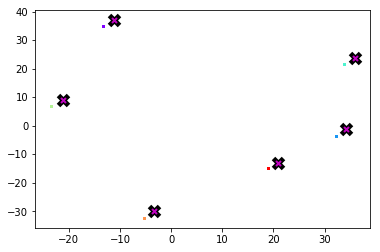

In [204]:
plot_data(centroids+2, X, n_samples)

## Broadcasting

How did our distance function `sqrt(((x-X)**2).sum(1))` work over a matrix without us writing any loops? The trick is that we used *broadcasting*. The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes.Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

Operators (+,-,\*,/,>,<,==) are usually element-wise. Here's some examples of element-wise operations:

In [68]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

a + b, a < b

(array([12, 14,  3]), array([False,  True,  True], dtype=bool))

Now this next example clearly can't be element-wise, since the second parameter is a scalar, not a 1d array.

In [69]:
a > 0

array([ True,  True, False], dtype=bool)

So how did this work? The trick was that numpy automatically *broadcast* the scalar `0` so that had the same `shape` as a. We can manually see how numpy broadcasts by using `broadcast_to()`.

In [72]:
a.shape

(3,)

In [73]:
np.broadcast_to(0, a.shape)

array([0, 0, 0])

In [74]:
np.broadcast_to(0, a.shape).shape

(3,)

Here's another example.

In [75]:
a + 1

array([11,  7, -3])

It works with higher-dimensional arrays too, for instance 2d (matrices):

In [76]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [77]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [80]:
m.shape

(3, 3)

In [79]:
np.broadcast_to(2, m.shape)

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

We can use the same trick to broadcast a vector to a matrix:

In [81]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [82]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Let's see what numpy has done with `c` in this case:

In [83]:
np.broadcast_to(c, m.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

Interesting - we see that it has duplicated `c` across rows. What if `c` was a column vector, i.e. a 3x1 array?

In [86]:
# Indexing an axis with None adds a unit axis in that location
cc = c[:,None]; cc

array([[10],
       [20],
       [30]])

In [87]:
m + cc

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

Let's see what numpy has done with `c` in this case:

In [88]:
np.broadcast_to(cc, m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

Note that numpy isn't actually replicating the memory of the axes being broadcast - it's simply looping over the same locations multiple times. This is very efficient both for compute and memory.

The behaviour of numpy's broadcasting seems quite intuitive, but you'll want to remember the explicit broadcasting rules to use this technique effectively:

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- They are equal, or
- One of them is 1.

When axes have the same dimension, no broadcasting is required. Any axes of dimension 1 are replicated to match the other array.

Arrays do not need to have the same number of dimensions. For example, if you have a 256 x 256 x 3 array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3
    
Numpy will insert additional unit axes as required to make the array few fewer dimensions math. So in this case the Scale array would be first reshaped automatically to 1x1x3, and then broadcast to 256 x 256 x 3. The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

We can now see how our `distance()` function works:

In [170]:
a=array([2,3])
b=array([[1,2],[2,3],[-1,1]])
c=(a-b)**2; c

array([[1, 1],
       [0, 0],
       [9, 4]])

In [182]:
w=gaussian(sqrt(c.sum(1)), 2.5); w

array([ 0.13598247,  0.15957691,  0.05640321])

...and we can also now pull apart our weighted average:

In [183]:
w.shape, b.shape

((3,), (3, 2))

In [184]:
w[:,None]

array([[ 0.13598247],
       [ 0.15957691],
       [ 0.05640321]])

In [185]:
w[:,None]*b

array([[ 0.13598247,  0.27196495],
       [ 0.31915382,  0.47873074],
       [-0.05640321,  0.05640321]])

In [186]:
(w[:,None]*b).sum(0) / w.sum()

array([ 1.13288486,  2.29313827])

## GPU-accelerated mean shift in pytorch

Let's now look at using [PyTorch](http://pytorch.org/), a Python framework for dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.

PyTorch has two overlapping, yet distinct, purposes.  As described in the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

The neural network functionality of PyTorch is built on top of the Numpy-like functionality for fast matrix computations on a GPU. Although the neural network purpose receives much more attention, both are very useful. Today we'll use PyTorch to accelerate our meanshift algorithm by running it on the GPU.

If you want to learn more PyTorch, you can try this [introductory tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [tutorial to learn by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

One advantage of pytorch is that it's very similar to numpy. For instance, in fact, our definitions of `gaussian` and `distance` and `meanshift_iter` are identical. So we'll simply import PyTorch's alternate implementations of the two numpy functions we use:

In [206]:
from torch import exp, sqrt

And then we'll use the exact same code as before, but first convert our numpy array to a GPU PyTorch tensor.

In [207]:
def meanshift(data):
    X = torch.from_numpy(np.copy(data)).cuda()
    for it in range(5): X = meanshift_iter(X)
    return X

Let's try it out...

CPU times: user 1.57 s, sys: 0 ns, total: 1.57 s
Wall time: 1.57 s


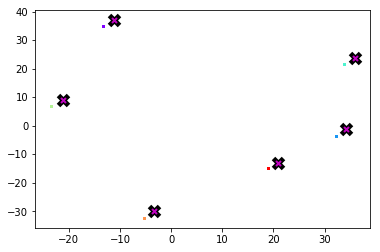

In [208]:
%time X = meanshift(data).cpu().numpy()
plot_data(centroids+2, X, n_samples)

It works, but this implementation actually takes longer. Oh dear! What do you think is causing this?

Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. To use the GPU effectively, we need to process a *batch* of data at a time.

## GPU batched algorithm

To process a batch of data, we need batched versions of our functions. Here's a version of `distance()` that works on batches:

In [214]:
def distance_b(a,b): return sqrt(((a[None,:] - b[:,None]) ** 2).sum(2))

In [215]:
a=torch.rand(2,2)
b=torch.rand(3,2)
distance_b(b, a)


 0.6237  0.3745  0.5868
 0.9674  0.8239  0.5793
[torch.FloatTensor of size 2x3]

Note how the two parameters to `distance_b()` have a unit axis added in two different places (`a[None,:]` and `b[:,None]`). This is a handy trick which effectively generalizes the concept of an 'outer product' to any function. In this case, we use it to get the distance from every point in `a` (our batch) to every point in `b` (the whole dataset).

Now that we have a suitable distance function, we can make some minor updates to our meanshift function to handle batches of data:

In [211]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(distance_b(X, X[s]), 2.5)
            num = (weight[:,:,None] * X).sum(1)
            X[s] = num / weight.sum(1)[:,None]
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [212]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 28 ms, sys: 52 ms, total: 80 ms
Wall time: 25.9 ms


That's more like it! We've gone from 2000ms to 26ms, which is a speedup of over 7000%. Oh, and it even gives the right answer!

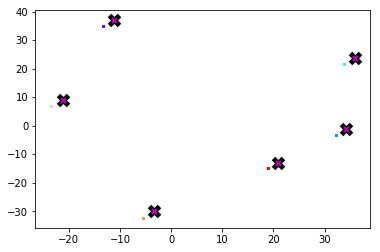

In [213]:
plot_data(centroids+2, X, n_samples)

## course.fast.ai

If you found this interesting, you might enjoy the 30+ hours of deep learning lessons at [course.fast.ai](course.fast.ai). There's also a very active forum of deep learning practitioners and learners at [forums.fast.ai](forums.fast.ai). Hope to see you there! :)